<a href="https://colab.research.google.com/github/ruochee723/SC3000-Balancing-Pole-on-Cart/blob/main/src/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [66]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

# gymlogger.set_level(40)  # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import math
import glob
import io
import base64

from typing import Tuple

random.seed(42)

## Task 1: Development of an RL agent

In [67]:
env = gym.make("CartPole-v1")

In [337]:
POSITION_RANGE = 4.8
ANGLE_RANGE = 0.418

NUM_BINS = {
    "position": 20,
    "velocity": 20,
    "pole_angle": 20,
    "pole_velocity": 20,
}

In [338]:
def discretize(x: float, min_val: float, max_val: float, num_bins: int) -> int:
    if x > max_val:
        return num_bins - 1
    elif x < min_val:
        return 0
    else:
        return round((x - min_val) / (max_val - min_val) * (num_bins - 1))

In [356]:
from scipy.special import expit as sigmoid
from typing import Dict


def get_num_states():
    num_states = 1
    for num_bins in NUM_BINS.values():
        num_states *= num_bins
    return num_states


NUM_STATES = get_num_states()


class Observation(object):
    def __init__(self, observation):
        if isinstance(observation, tuple):
            observation = observation[0]
        if not isinstance(observation, np.ndarray):
            gymlogger.error(f"Error: Observation ({observation}) is not a numpy array")
            raise ValueError("Observation is not a numpy array")
        if observation.shape != (4,):
            gymlogger.error(
                f"Error: Observation shape ({observation.shape}) is not (4,)"
            )
            raise ValueError("Observation shape is not (4,)")
        self.observation = observation

    def position(self):
        return self.observation[0]

    def velocity(self):
        return self.observation[1]

    def pole_angle(self):
        return self.observation[2]

    def pole_velocity(self):
        return self.observation[3]

    def get_hashed_state_dict(self) -> Dict[str, int]:
        return {
            "position": discretize(
                self.position(), -POSITION_RANGE, POSITION_RANGE, NUM_BINS["position"]
            ),
            "velocity": discretize(
                sigmoid(self.velocity()),
                -1,
                1,
                NUM_BINS["velocity"],
            ),
            "pole_angle": discretize(
                self.pole_angle(), -ANGLE_RANGE, ANGLE_RANGE, NUM_BINS["pole_angle"]
            ),
            "pole_velocity": discretize(
                sigmoid(self.pole_velocity()),
                -1,
                1,
                NUM_BINS["pole_velocity"],
            ),
        }

    def get_hashed_state(self) -> int:
        hashed_state_tuple = self.get_hashed_state_dict()
        mul = 1
        hashed_state = 0
        for key, val in hashed_state_tuple.items():
            hashed_state += val * mul
            mul *= NUM_BINS[key]
        assert 0 <= hashed_state < NUM_STATES
        return hashed_state


def get_hashed_state(observation: np.ndarray) -> int:
    return Observation(observation).get_hashed_state()

### Abstract Class for RL Agent

In [357]:
from abc import ABC, abstractmethod


class Agent(ABC):
    def __init__(self, name: str):
        self.name = name

    @abstractmethod
    def _get_action(self, observation: Observation) -> int:
        raise NotImplementedError

    def get_action(self, observation: np.ndarray) -> int:
        return self._get_action(Observation(observation))

    def __call__(self, observation: np.ndarray) -> int:
        return self.get_action(observation)

### Random Agent

In [358]:
class RandomAgent(Agent):
    def __init__(self):
        super().__init__("RandomAgent")

    def _get_action(self, observation: Observation) -> int:
        return random.randint(0, 1)

### Q Learning Agent

In [359]:
from tqdm import trange


class QLearningAgent(Agent):
    def __init__(
        self,
        *,
        state_space_size: int = NUM_STATES,
        action_space_size: int = 2,
        alpha: float = 0.1,
        gamma: float = 0.99,
        epsilon: float = 0.1,
    ):
        super().__init__("QLearningAgent")
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((state_space_size, action_space_size))

    def reset(self):
        self.q_table = np.zeros((self.state_space_size, self.action_space_size))

    def _get_action(self, observation: Observation) -> int:
        return np.argmax(self.q_table[observation.get_hashed_state(), :])

    def train_episode(self, env: gym.Env):
        observation = env.reset()
        state = get_hashed_state(observation)
        done = False
        truncated = False
        while not done and not truncated:
            if random.random() < self.epsilon:
                action = random.randint(0, 1)
            else:
                action = self.get_action(observation)
            next_observation, reward, done, truncated, info = env.step(action)
            next_state = get_hashed_state(next_observation)
            self.q_table[state, action] += self.alpha * (
                reward
                + self.gamma * np.max(self.q_table[next_state, :])
                - self.q_table[state, action]
            )
            state = next_state
            observation = next_observation

    def train(self, env: gym.Env = None, *, num_episodes: int = 1000) -> np.ndarray:
        if env is None:
            env = gym.make("CartPole-v1")
        episode_rewards = []
        for episode in trange(
            num_episodes, desc="Training Q-Learning Agent", unit="episode"
        ):
            episode_rewards.append(self.train_episode(env))

For Task 1, we can show the observation and chosen action below:

In [360]:
observation = env.reset()
q_learning_agent = QLearningAgent()
q_learning_agent.train(env)
action = q_learning_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Training Q-Learning Agent: 100%|██████████| 1000/1000 [00:01<00:00, 872.08episode/s]

Observation: (array([-0.0220827 ,  0.04356645,  0.00591842, -0.02577775], dtype=float32), {})
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [344]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


def play_episode(agent: Agent, env: gym.Env) -> float:
    observation = env.reset()
    done = False
    truncated = False
    reward = 0
    while not done and not truncated:
        action = agent(observation)
        next_observation, r, done, truncated, info = env.step(action)
        reward += r
        observation = next_observation
    return reward


def play(agent: Agent, num_episodes: int = 1000, num_threads: int = 1):
    all_rewards = []

    progress_bar = tqdm(total=num_episodes, desc="Playing", unit="episode")

    def play_multiple_episodes(episodes: int, rank: int):
        env = gym.make("CartPole-v1")
        rewards = []
        for i in range(episodes):
            progress_bar.update(1)
            rewards.append(play_episode(agent, env))
        return rewards

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        threads_loads = [num_episodes // num_threads] * num_threads
        threads_loads[-1] += num_episodes % num_threads
        all_rewards = sum(
            executor.map(play_multiple_episodes, threads_loads, range(num_threads)), []
        )

    progress_bar.close()

    return np.array(all_rewards)

Playing:   0%|          | 0/100 [00:00<?, ?episode/s]/data/fypu/anaconda3/envs/SC3000/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Playing: 100%|██████████| 100/100 [01:11<00:00,  1.41episode/s]


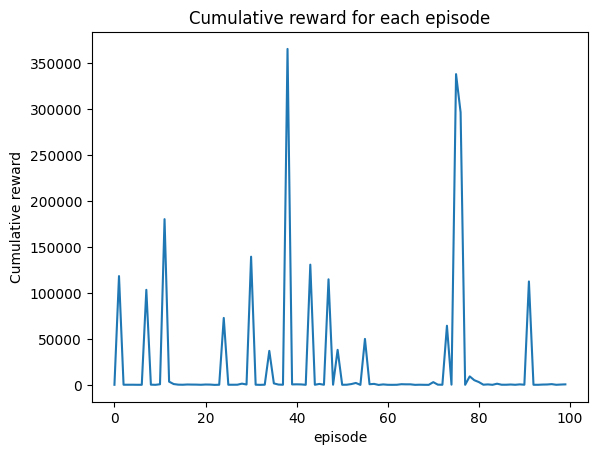

In [361]:
q_learning_agent = QLearningAgent(alpha=0.1, epsilon=0.5, gamma=0.999)
q_learning_agent.train(env, num_episodes=10000)
q_learning_agent.alpha = 0.05
q_learning_agent.epsilon = 0.1
q_learning_agent.train(env, num_episodes=10000)
episode_results = play(q_learning_agent, num_episodes=100, num_threads=30)
plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

Print the average reward over the 100 episodes.

In [355]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 110.21
Is my agent good enough? False


## Task 3: Render one episode played by the agent

In [96]:
import os
import imageio
import datetime
from PIL import Image
from IPython.display import Video


def get_video_path(
    agent: Agent, *, video_name: str = "default", video_folder: str = "video"
) -> str:
    os.makedirs(video_folder, exist_ok=True)
    if video_name == "default":
        video_name = f"{agent.name}_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
    if not video_name.endswith(".mp4"):
        video_name += ".mp4"
    return os.path.join(video_folder, video_name)


def render(
    agent: Agent,
    video_name: str = "default",
    fps: int = 20,
    width: int = 600,
    height: int = 400,
    video_folder: str = "video",
):
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    frames = []
    observation = env.reset()
    while True:
        frames.append(Image.fromarray(env.render()).resize((width, height)))
        action = agent(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated:
            break

    env.close()

    video_path = get_video_path(agent, video_name=video_name, video_folder=video_folder)
    imageio.mimsave(video_path, frames, fps=fps)

    return Video(video_path)

In [219]:
q_learning_agent = QLearningAgent()
q_learning_agent.train(env, num_episodes=10000)
None

Training Q-Learning Agent: 100%|██████████| 10000/10000 [00:25<00:00, 392.81episode/s]


In [364]:
render(q_learning_agent)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7294c40] Warning: data is not aligned! This can lead to a speed loss
